# Working with ORAS5 data 

Creating an alternative climatology from this longer time series to be used with our OSNAP data

In [68]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pandas as pd
import scipy

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#font = {'weight' : 'normal','size' : 10}
#plt.rc('font', **font)

# Import Data

In [4]:
file_name = "data/ORAS5.nc"
oras5 = xr.open_dataset(file_name)
oras5=oras5.rename({'depth':'DEPTH','time':'TIME'})

In [5]:
#depth_E = [50, 75, 100, 250, 500, 750, 950, 1000, 1250, 1500, 1600, 1750] 
#depth_W = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]

In [6]:
# all years
#oras5_EB = oras5.thetao_oras.sel(latitude = 57.1, longitude = -9.6, method = 'nearest')
#oras5_WB = oras5.thetao_oras.sel(latitude = 57.5, longitude = -12.5, method = 'nearest')

In [7]:
# 10 years
oras5_EB_10 = oras5.thetao_oras.sel(latitude = 57.1, longitude = -9.6, method = 'nearest').sel(TIME=slice('2014-01-01', '2019-12-31')).isel(DEPTH=slice(0,50))
oras5_WB_10 = oras5.thetao_oras.sel(latitude = 57.5, longitude = -12.5, method = 'nearest').sel(TIME=slice('2014-01-01', '2019-12-31')).isel(DEPTH=slice(0,50))

In [69]:
oras5_EB_depth = oras5.thetao_oras.sel(latitude = 57.1, longitude = -9.6, method = 'nearest').sel(TIME=slice('2014-01-01', '2019-12-31')).isel(DEPTH=slice(0,50))


In [9]:
oras5_EB_10

<xarray.DataArray 'thetao_oras' (TIME: 2191, DEPTH: 50)>
[109550 values with dtype=float32]
Coordinates:
  * DEPTH      (DEPTH) float32 0.5058 1.556 2.668 ... 1.266e+03 1.387e+03
    latitude   float32 57.0
  * TIME       (TIME) datetime64[ns] 2014-01-01 2014-01-02 ... 2019-12-31
    longitude  float32 -9.5
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288]

In [10]:
oras5_WB_10

<xarray.DataArray 'thetao_oras' (TIME: 2191, DEPTH: 50)>
[109550 values with dtype=float32]
Coordinates:
  * DEPTH      (DEPTH) float32 0.5058 1.556 2.668 ... 1.266e+03 1.387e+03
    latitude   float32 57.5
  * TIME       (TIME) datetime64[ns] 2014-01-01 2014-01-02 ... 2019-12-31
    longitude  float32 -12.5
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288]

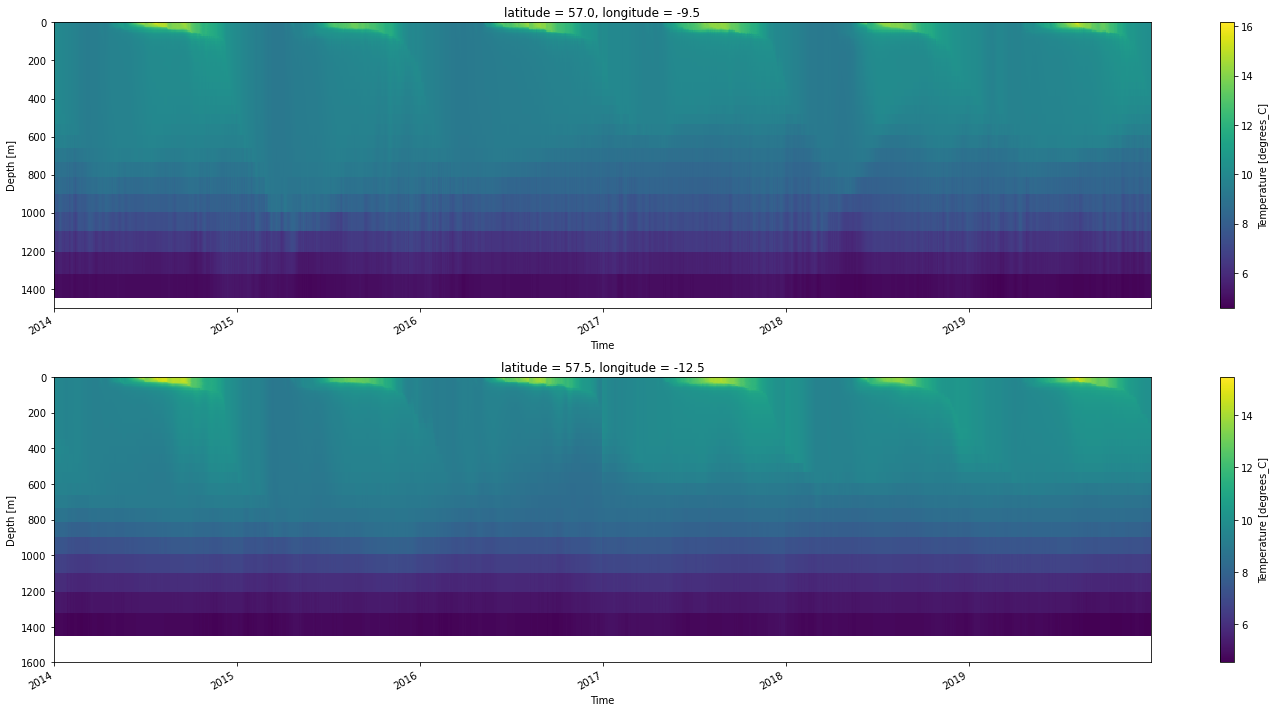

In [11]:
fig, ax = plt.subplots(2,1, figsize = (20, 10))
oras5_EB_10.plot(x='TIME', y='DEPTH', yincrease = False, ax = ax[0])
ax[0].set_ylim(1500,0)
oras5_WB_10.plot(x='TIME', y='DEPTH', yincrease = False,ax = ax[1])
ax[1].set_ylim(1600,0)
fig.tight_layout();

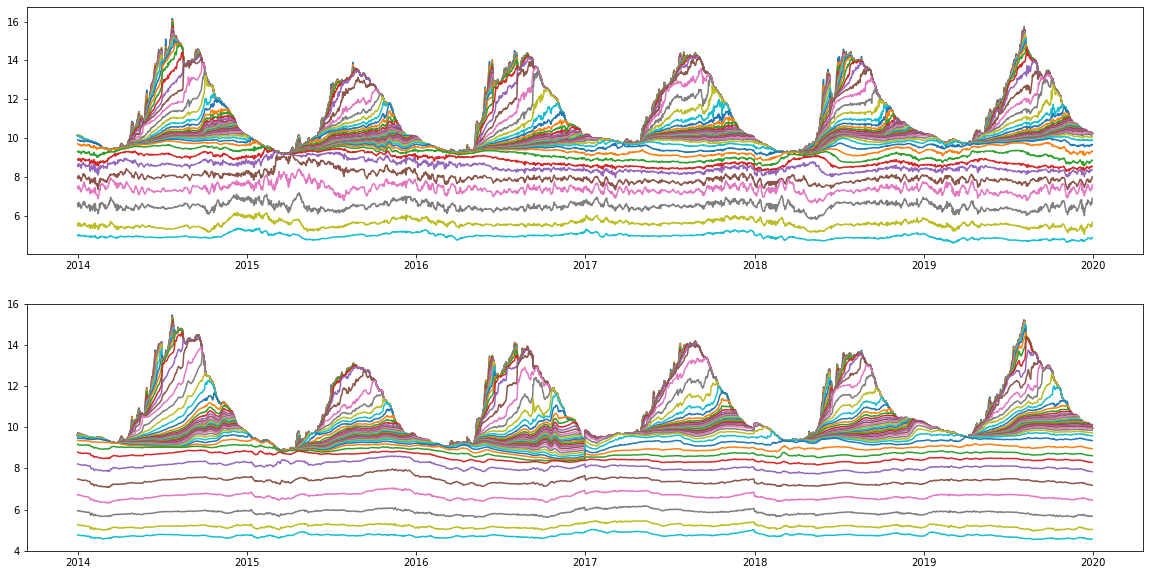

In [13]:
fig, ax = plt.subplots(2,1, figsize = (20,10))
ax[0].plot(oras5_EB_10.TIME, oras5_EB_10)
ax[1].plot(oras5_WB_10.TIME, oras5_WB_10);

# Functions

In [14]:
def MHW_func (data, depth): #, climP=[1993.0,2019.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   
    
    mhws, clim = mhw.detect(t, temp) #, climatologyPeriod=climP, alternateClimatology=altClim)     
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True) #, climatologyPeriod=climP, alternateClimatology=altClim)     
    return mhws, mcss, clim, clim_cold, t, temp  

In [15]:
def DICT_func(data, depth): #, climP=[1993.0,2019.0], altClim=False):  
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}
   
    for n in depth:
        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n) #, climP, altClim)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [16]:
def OV_stacked_ax_events(dict, n, num):

    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]   
        ax[num].axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink', label = 'MHWs')

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        ax[num].axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan', label = 'MCSs')

    #ax[num].set_xlim(date(2014,7,15), date(2020,10,20))
    ax[num].grid(axis = 'x')
    ax[num].set_ylabel(str(n),rotation=0, labelpad=20)
       
    ax[num].tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False);
    

In [17]:
def OV_stacked_events(dict, depth, w, h, title='bla'):
    
    fig, ax = plt.subplots(len(depth),1, figsize=(w,h), sharex = True)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    
    for i,n in enumerate(depth):
        mhws = dict['mhws'][str(n)]
        mcss = dict['mcss'][str(n)]
        d = dict['t'][str(n)]
        temp = dict['temp'][str(n)]
        clim = dict['clim'][str(n)]
        clim_cold = dict['clim_cold'][str(n)]
        
        bla = np.array(dict['temp'][str(n)])
        if any(~np.isnan(bla)):

            dates = [date.fromordinal(tt.astype(int)) for tt in d]

            ev = (mhws['n_events'])
            ec = (mcss['n_events'])

            # Find all MHWs and shade
            for ev0 in np.arange (ev):
                t1 = np.where(d==mhws['time_start'][ev0])[0][0]
                t2 = np.where(d==mhws['time_end'][ev0])[0][0]   
                ax[i].axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink', label = 'MHWs')

            # same for cold spells
            for ec0 in np.arange(ec):
                tc1 = np.where(d==mcss['time_start'][ec0])[0][0]
                tc2 = np.where(d==mcss['time_end'][ec0])[0][0]
                ax[i].axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan', label = 'MCSs')

            #ax[num].set_xlim(date(2014,7,15), date(2020,10,20))
            ax[i].grid(axis = 'x')
            ax[i].set_ylabel(str(n),rotation=0, labelpad=20)
            if i == 0:
                ax[i].set_title(title)

            ax[i].tick_params(axis='y', which='both', right=False,
                        left=False, labelleft=False);


In [81]:
def ALL_events(dict, depth):

    fig, ax = plt.subplots(len(depth), 1, figsize = (20,100))
    fig.subplots_adjust(hspace=3)
    fig.tight_layout()
    for i,n in enumerate(depth):
        #defining my variables
        mhws = dict['mhws'][str(n)]
        mcss = dict['mcss'][str(n)]
        t = dict['t'][str(n)]
        temp = dict['temp'][str(n)]
        clim = dict['clim'][str(n)]
        clim_cold = dict['clim_cold'][str(n)]

        ev = (mhws['n_events'])
        ec = (mcss['n_events'])
        
        dates = [date.fromordinal(tt.astype(int)) for tt in t]

        ax[i].plot(dates, clim['thresh'], ':r', label = 'Threshold warm')
        ax[i].plot(dates, clim_cold['thresh'], ':g', label = 'Threshold cold')
        ax[i].plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
        ax[i].plot(dates, clim['seas'], 'b', label = 'Climatology')
        ax[0].legend()
        ax[i].set_title(f'MHWs and MCSs {n}')
        ax[i].grid()


        # Find all MHWs and shade
        for ev0 in np.arange (ev):
            t1 = np.where(t==mhws['time_start'][ev0])[0][0]
            t2 = np.where(t==mhws['time_end'][ev0])[0][0]
            ax[i].axvspan(xmin=dates[t1], xmax=dates[t2], \
                             color='deeppink')

        # same for cold spells
        for ec0 in np.arange(ec):
            tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
            tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
            ax[i].axvspan(xmin=dates[tc1], xmax=dates[tc2], \
                             color='darkcyan', alpha=0.4)

        #plt.ylabel('°C');
        ax[i].tick_params(axis='y', which='both', right=False,
                    left=False, labelleft=False);
        ax[i].set_ylabel(str(n),rotation=0, labelpad=20)





# Dictionary

In [20]:
depth_EB = np.array(oras5_EB_10.DEPTH).astype(int)
depth_WB = np.array(oras5_WB_10.DEPTH).astype(int)

In [66]:
depth_de = np.array(oras5_EB_depth.DEPTH.isel(DEPTH=slice(0,50))).astype(int)

In [67]:
depth_de

array([   0,    1,    2,    3,    5,    6,    8,    9,   11,   13,   16,
         19,   22,   26,   30,   35,   41,   47,   53,   61,   69,   77,
         86,   97,  108,  120,  133,  147,  163,  180,  199,  221,  244,
        271,  300,  333,  370,  411,  457,  508,  565,  628,  697,  773,
        856,  947, 1045, 1151, 1265, 1387])

In [22]:
ora_EB = DICT_func(oras5_EB_10, depth_EB)
ora_WB = DICT_func(oras5_WB_10, depth_WB)

In [23]:
ora_de = DICT_func(oras5_EB_depth, depth_de)

# Plots EB

In [24]:
depth_EB

array([   0,    1,    2,    3,    5,    6,    8,    9,   11,   13,   16,
         19,   22,   26,   30,   35,   41,   47,   53,   61,   69,   77,
         86,   97,  108,  120,  133,  147,  163,  180,  199,  221,  244,
        271,  300,  333,  370,  411,  457,  508,  565,  628,  697,  773,
        856,  947, 1045, 1151, 1265, 1387])

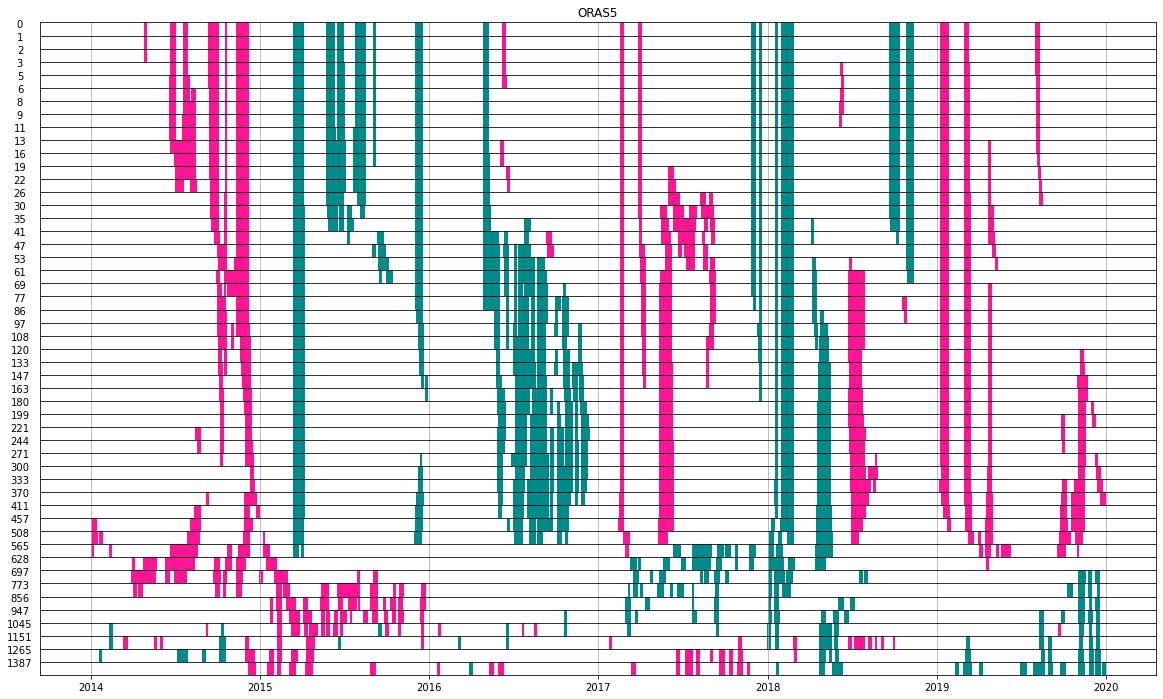

In [32]:
OV_stacked_events(ora_EB, depth_EB, 20, 12, 'ORAS5')

In [80]:
#for n in depth_de:
#    if (n > 1500): break
#    print(n)

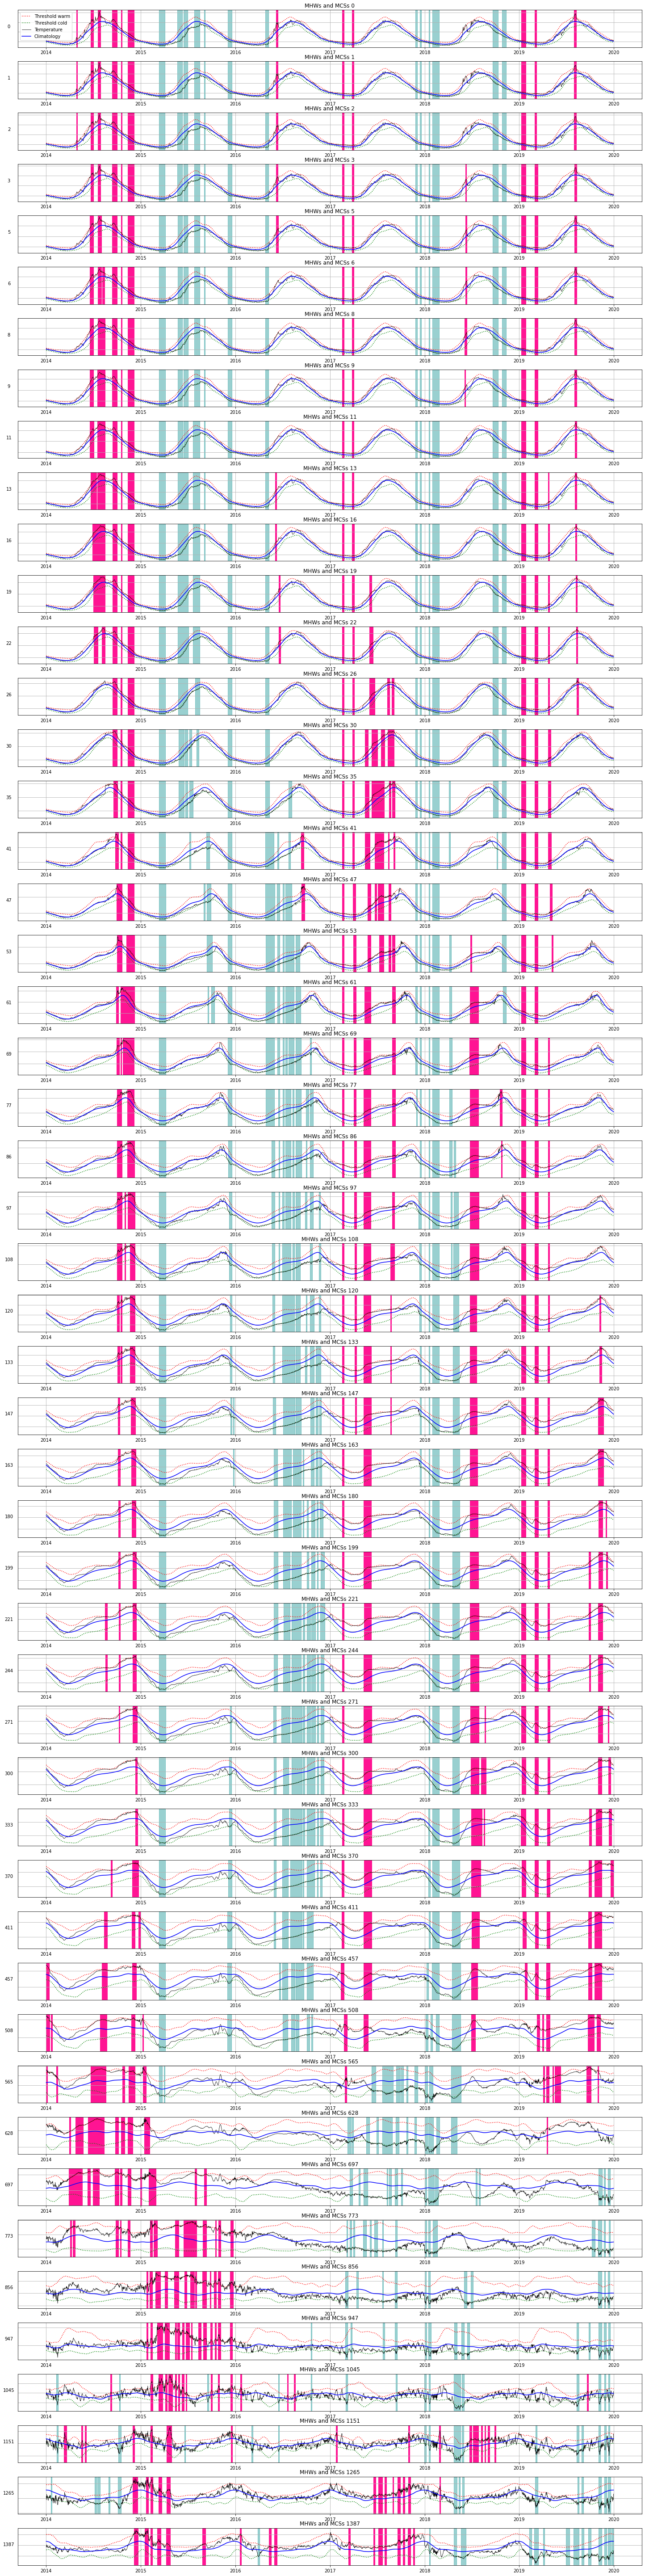

In [79]:
ALL_events(ora_de, depth_EB)

# Plots WB

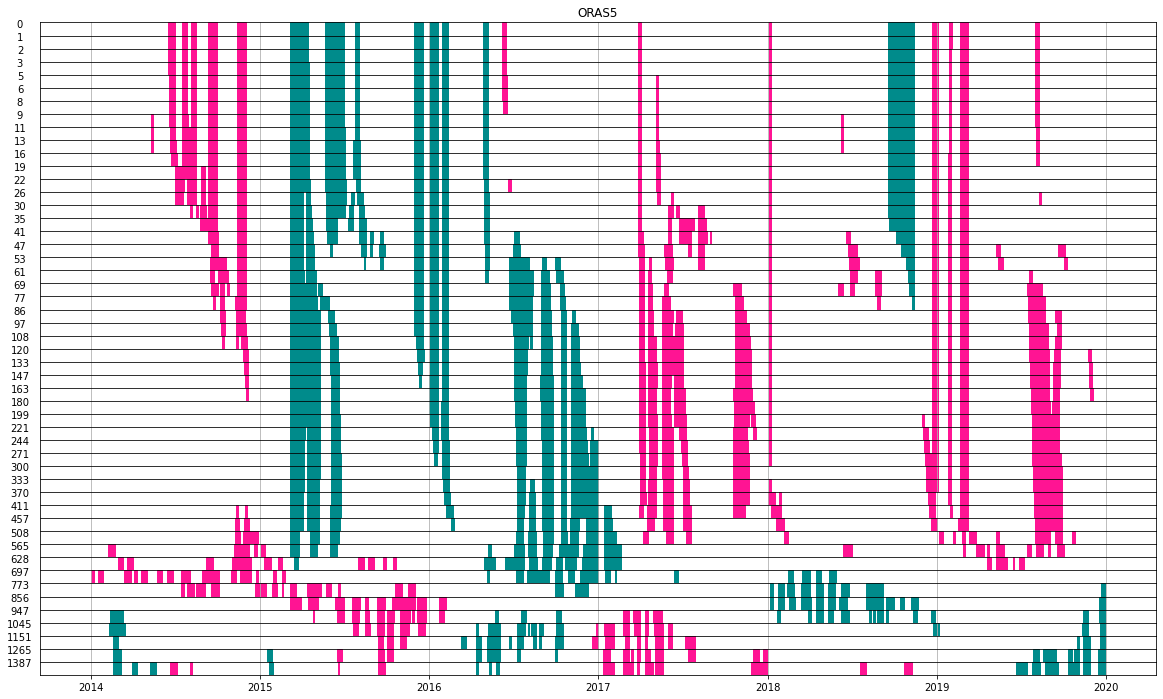

In [27]:
OV_stacked_events(ora_WB, depth_WB, 20, 12, 'ORAS5')